In [14]:
import torch
import numpy as np
import pandas as pd
import h5py
import re
import warnings
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)

# Set device (use MPS for Mac, CUDA for GPU, else CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [10]:
# Reload necessary libraries after execution state reset
import h5py
import numpy as np
import pandas as pd

# Load the HDF5 file
file_path = "../lotka_volterra_data.h5"

# Read dataset contents
with h5py.File(file_path, "r") as f:
    trajectories = f["trajectories"][:]  # Shape: (1000, 100, 2)
    time_points = f["time"][:]  # Shape: (100,)

# Convert to DataFrame for easy visualization
num_samples = 1000

data_dict = {
    "Time": np.tile(time_points, num_samples),
    "Prey Population": trajectories[:num_samples, :, 0].flatten(),
    "Predator Population": trajectories[:num_samples, :, 1].flatten(),
    "Sample ID": np.repeat(range(num_samples), len(time_points)),
}

df = pd.DataFrame(data_dict)



In [8]:
df

,Time,Prey Population,Predator Population,Sample ID
0,0.000000,0.949917,1.040624,0
1,2.020202,0.740551,0.779542,0
2,4.040404,0.682246,0.564390,0
3,6.060606,0.716674,0.407644,0
4,8.080808,0.824511,0.300283,0
...,...,...,...,...
9995,191.919192,2.572118,0.143187,99
9996,193.939394,2.700390,0.148099,99
9997,195.959596,2.816474,0.156708,99
9998,197.979798,2.912550,0.169054,99


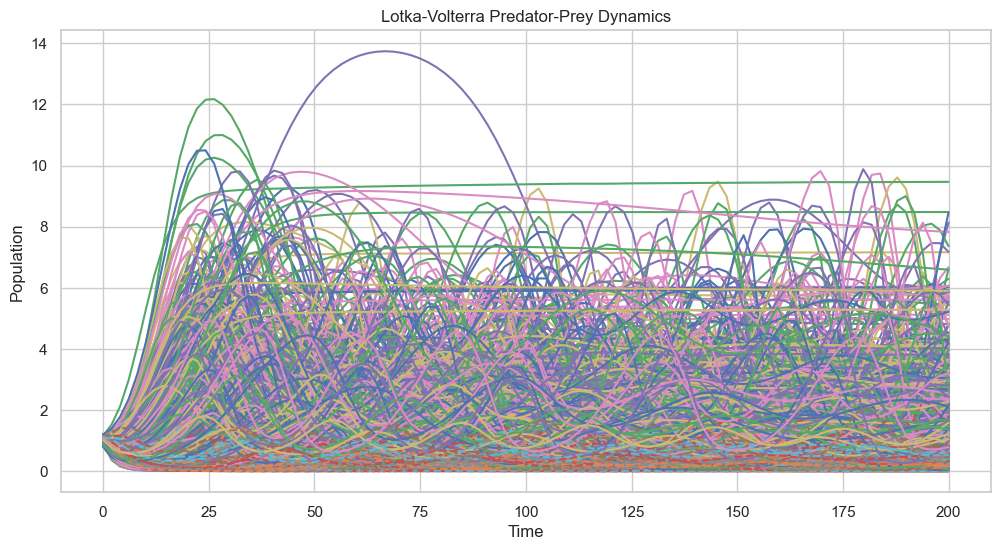

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns


# Unique sample IDs
sample_ids = df["Sample ID"].unique()

# Create a figure
plt.figure(figsize=(12, 6))

# Plot prey and predator populations over time for each sample
for sample_id in sample_ids:
    subset = df[df["Sample ID"] == sample_id]
    plt.plot(subset["Time"], subset["Prey Population"], label=f"Prey (Sample {sample_id})", linestyle="-")
    plt.plot(subset["Time"], subset["Predator Population"], label=f"Predator (Sample {sample_id})", linestyle="--")

# Labels and title
plt.xlabel("Time")
plt.ylabel("Population")
plt.title("Lotka-Volterra Predator-Prey Dynamics")
plt.show()


In [17]:
# Load tokenizer and model
model_name = "Qwen/Qwen2.5-0.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

# Fix tokenizer padding issue
tokenizer.padding_side = "left"

print("✅ Model and tokenizer loaded successfully!")


/Users/raunaqrai/miniconda_x86_64/lib/python3.12/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


✅ Model and tokenizer loaded successfully!


In [18]:
def preprocess_sequences(trajectories, num_samples=5, decimal_places=2):
    """
    Converts raw trajectories into formatted text sequences for Qwen input.
    """
    formatted_sequences = []
    
    for i in range(num_samples):
        # Extract prey and predator data, rounding for consistency
        formatted_seq = ";".join([
            f"{round(prey, decimal_places)},{round(predator, decimal_places)}"
            for prey, predator in zip(trajectories[i, :, 0], trajectories[i, :, 1])
        ])
        formatted_sequences.append(formatted_seq)
    
    return formatted_sequences

# Convert data to formatted sequences
formatted_sequences = preprocess_sequences(trajectories, num_samples=5)
print(f"✅ Preprocessed Sample:\n{formatted_sequences[0][:100]}...")  # Show first 100 characters


✅ Preprocessed Sample:
0.949999988079071,1.0399999618530273;0.7400000095367432,0.7799999713897705;0.6800000071525574,0.5600...


In [19]:
def generate_forecasts(model, tokenizer, text_inputs, max_new_tokens=10):
    """
    Uses the Qwen model to generate forecasts from time-series inputs.
    """
    instruction = "Given the following time series, predict the next values:\n"
    modified_inputs = [instruction + seq for seq in text_inputs]

    input_ids = tokenizer(modified_inputs, return_tensors="pt", padding=True, truncation=True)["input_ids"].to(device)

    with torch.no_grad():
        output = model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            attention_mask=torch.ones_like(input_ids),
            do_sample=True,  
            top_k=50,  
            temperature=0.9,  
        )

    # Decode output into text
    predicted_texts = tokenizer.batch_decode(output, skip_special_tokens=True)
    
    print(f"\n🔍 Raw Model Output:\n{predicted_texts}")  # Debugging output
    return predicted_texts

# Generate predictions
predicted_texts = generate_forecasts(model, tokenizer, formatted_sequences)



🔍 Raw Model Output:
['Given the following time series, predict the next values:\n0.949999988079071,1.0399999618530273;0.7400000095367432,0.7799999713897705;0.6800000071525574,0.5600000023841858;0.7200000286102295,0.4099999964237213;0.8199999928474426,0.30000001192092896;1.0,0.23000000417232513;1.2599999904632568,0.1899999976158142;1.6100000143051147,0.1599999964237213;2.0299999713897705,0.15000000596046448;2.5199999809265137,0.1599999964237213;3.0399999618530273,0.1899999976158142;3.5199999809265137,0.23999999463558197;3.859999895095825,0.3199999928474426;3.9800000190734863,0.44999998807907104;3.7799999713897705,0.6299999952316284;3.259999990463257,0.8299999833106995;2.549999952316284,0.9800000190734863;1.8799999952316284,1.0199999809265137;1.409999966621399,0.9300000071525574;1.1399999856948853,0.7799999713897705;1.0299999713897705,0.6200000047683716;1.0299999713897705,0.49000000953674316;1.1100000143051147,0.38999998569488525;1.2599999904632568,0.3199999928474426;1.4800000190734863,

In [20]:
def extract_numeric_values(text):
    """
    Extracts numeric values from model output while ignoring text.
    """
    print(f"📝 Extracting from: {text}")

    # Remove instruction remnants
    text = text.replace("Given the following time series, predict the next values:", "").strip()

    # Extract numbers
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", text)

    # Convert to float
    try:
        numeric_values = [float(num) for num in numbers]
    except ValueError:
        print(f"🚨 Conversion Error! Non-numeric values in: {text}")
        numeric_values = []

    return numeric_values if numeric_values else [0.0]  # Ensure valid output

# Convert predictions into numeric sequences
predicted_values = [extract_numeric_values(text) for text in predicted_texts]

# Display the first prediction for review
print(f"✅ Processed Model Prediction:\n{predicted_values[0]}")


📝 Extracting from: Given the following time series, predict the next values:
0.949999988079071,1.0399999618530273;0.7400000095367432,0.7799999713897705;0.6800000071525574,0.5600000023841858;0.7200000286102295,0.4099999964237213;0.8199999928474426,0.30000001192092896;1.0,0.23000000417232513;1.2599999904632568,0.1899999976158142;1.6100000143051147,0.1599999964237213;2.0299999713897705,0.15000000596046448;2.5199999809265137,0.1599999964237213;3.0399999618530273,0.1899999976158142;3.5199999809265137,0.23999999463558197;3.859999895095825,0.3199999928474426;3.9800000190734863,0.44999998807907104;3.7799999713897705,0.6299999952316284;3.259999990463257,0.8299999833106995;2.549999952316284,0.9800000190734863;1.8799999952316284,1.0199999809265137;1.409999966621399,0.9300000071525574;1.1399999856948853,0.7799999713897705;1.0299999713897705,0.6200000047683716;1.0299999713897705,0.49000000953674316;1.1100000143051147,0.38999998569488525;1.2599999904632568,0.3199999928474426;1.4800000190734863,0.270

In [ ]:
def evaluate_predictions(ground_truth, predictions):
    """
    Evaluates model performance using standard metrics.
    """
    # Ensure predicted values match valid ground truth length
    predictions = [
        pred[:len(gt)] if len(pred) >= len(gt) else pred + [0] * (len(gt) - len(pred))
        for pred, gt in zip(predictions, ground_truth)
    ]

    mse = mean_squared_error(ground_truth, predictions)
    mae = mean_absolute_error(ground_truth, predictions)
    r2 = r2_score(ground_truth, predictions)

    return mse, mae, r2

# Convert ground truth into numerical sequences
ground_truth_values = [list(map(float, seq.replace(";", ",").split(","))) for seq in formatted_sequences]

# Evaluate model performance
mse, mae, r2 = evaluate_predictions(ground_truth_values, predicted_values)

print(f"\n **Evaluation Metrics:**")
print(f" Mean Squared Error (MSE): {mse:.4f}")
print(f" Mean Absolute Error (MAE): {mae:.4f}")
print(f" R² Score: {r2:.4f}")



 **Evaluation Metrics:**
 Mean Squared Error (MSE): 0.0000
 Mean Absolute Error (MAE): 0.0000
 R² Score: 1.0000

 **Example 1:**
 **Ground Truth:** [0.949999988079071, 1.0399999618530273, 0.7400000095367432, 0.7799999713897705, 0.6800000071525574, 0.5600000023841858, 0.7200000286102295, 0.4099999964237213, 0.8199999928474426, 0.30000001192092896] ...
 **Model Prediction (Adjusted):** [0.949999988079071, 1.0399999618530273, 0.7400000095367432, 0.7799999713897705, 0.6800000071525574, 0.5600000023841858, 0.7200000286102295, 0.4099999964237213, 0.8199999928474426, 0.30000001192092896] ...

 **Example 2:**
 **Ground Truth:** [0.9700000286102295, 1.0099999904632568, 1.0800000429153442, 0.8199999928474426, 1.2599999904632568, 0.6899999976158142, 1.5199999809265137, 0.5899999737739563, 1.8600000143051147, 0.5400000214576721] ...
 **Model Prediction (Adjusted):** [0.9700000286102295, 1.0099999904632568, 1.0800000429153442, 0.8199999928474426, 1.2599999904632568, 0.6899999976158142, 1.519999980